Новая презентация

https://disk.yandex.ru/i/CDsLohkY3AzvNA

## Описание данных

Цель исследования - выявить характеристики клиентов, которые склонны к уходу из банка. Дать рекомендации отделу маркетинга, нацеленные на снижение оттока клиентов, исходя из проведенного анализа.

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

## Подготовка данных

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import math

pd.options.mode.chained_assignment = None  

In [3]:
df = pd.read_csv('/datasets/bank_dataset.csv')

In [4]:
df.head(10)

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0
5,15616748,645,Рыбинск,М,44,8,113755.78,2,1,0,149756.71,1
6,15635267,822,Ярославль,М,50,7,NaN,2,1,1,10062.80,0
7,15698884,376,Ростов Великий,Ж,29,4,115046.74,4,1,0,119346.88,1
8,15835101,501,Ярославль,М,44,4,142051.07,2,0,1,74940.50,0
9,15635125,684,Ярославль,М,27,2,134603.88,1,1,1,71725.73,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


### Предобработка данных

В датасете 10000 строк и 12 столбцов.

Названия некоторых столбцов содержат заглавные буквы, это можно исправить. Также названия некоторых столбцов для красоты можно привести к змеиному регистру.

Пропуски в данных есть только в столбце с балансом.

In [6]:
#уберем из названия столбцов заглавные буквы
df.columns = df.columns.str.lower()

In [7]:
#приведем названия некоторые столбцов к змеиному регистру
df.rename(columns = {'userid':'user_id', 'creditcard':'credit_card'}, inplace = True)

In [8]:
df.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'credit_card', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')

In [9]:
#проверим данные на явные дубликаты
df.duplicated().sum()

0

Явных дубликатов нет.

In [10]:
len(df[df['balance'].isna()])

3617

В столбце с балансом 3617 пропусков, то есть в 36% случаев в данном столбце отсутствует информация.

In [11]:
#посмотрим на распределение пропусков в столбце с балансом по городам
df[df['balance'].isna()].groupby('city')['city'].count()

city
Рыбинск      1199
Ярославль    2418
Name: city, dtype: int64

In [12]:
df.groupby('city')['city'].count()

city
Ростов Великий    2509
Рыбинск           2477
Ярославль         5014
Name: city, dtype: int64

Примечательно, что у клиентов из Ростова Великого нет ни одного пропуска в столбце с балансом, хотя их доля составляет 25% от общего числа клиентов.
В Ярославле и Рыбинске нет данных о балансе примерно у каждого второго клиента.

In [13]:
df['balance'].describe()

count      6383.000000
mean     119827.493793
std       30095.056462
min        3768.690000
25%      100181.975000
50%      119839.690000
75%      139512.290000
max      250898.090000
Name: balance, dtype: float64

Т.к. пропуски в балансе распространяются не на весь датасет, а на 2 города, то можно предположить, что причина их появления в техническом сбое применительно к филиалам конкретно в этих 2 городах. Можно также предположить, что пропуск в столбце соответствует клиенту без дебетовой карты/вклада/накопительного счета, но почему-то актуально это только для Рыбинска и Ярославля.

Пропуски в данных не должны помешать анализу, поэтому избавляться от них не будем.

### Проверка данных на реалистичность

In [14]:
df.describe()

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.573368e+07,650.528800,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.560844e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.567126e+07,584.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.573347e+07,652.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.579597e+07,718.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.585843e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Проверим данные на реалистичность:

1. Минимальное значение кредитного скоринга в датасете - 350, максимальное - 850. Согласно ресурсу sravni.ru (https://www.sravni.ru/enciklopediya/info/skoringovyi-ball/), шансы получить кредит есть при кредитном рейтинге от 600 баллов, поэтому аномалий нет.

2. Значения возраста распределены от 18 до 92 лет. Аномалий нет, т.к. в датасете представлены не только заемщики, а пользователи банка в целом, поэтому в 92 года кто-то может получить пенсию на карту банка.

3. 
    * Значения заработной платы варьируются от 11 рублей до 200000 рублей. С верхним пределом - все нормально. Нижний предел вызывает подозрения. Здесь, скорее всего, в качестве заработной платы может выступать и пособие. Минимальное пособие по безработице в 21-22 гг составляло 1500 руб. в месяц. Клиентов с ежемесячным доходом ниже 1500 руб. - 83 человека. 

    * При этом среди этих 83 человек баланс на счете в среднем составляет 115 тыс, что не мало.

    * Возможно также было бы предположить, что в категорию заработной платы могла попадать стипендия, тогда минимальный размер стипендии для колледжей в 638 руб мог бы объяснить нахождение среди 83 человек большого количества людей возраста 18-20. Но гистограмма ниже показывает, что в основном среди этих 83 человек люди в возрастной категории 30-40.
    
    * Также причина могла быть в невнимательном операторе, забивающим данные, но распределение людей с низкой заработной платой равномерно среди трех городов, поэтому данная версия также не подходит под объяснение.

4. В целом можно заметить, что в датасете завышенная средняя заработная плата по Ярославской области и заниженный средний уровень баланса на счете клиентов. Так, средняя заработная плата в Ярославской области по последний данным Росстата (https://bankiros.ru/wiki/term/crednaa-zarplata-v-aroslavle) составляла 40307 рублей в месяц. 

5. Также можно отметить подозрительно большое кол-во объектов в собственности у клиентов - 5 шт.

6. Остальные столбцы не вызывают вопросов.

In [15]:
len(df.query('estimated_salary < 1500'))

83

In [16]:
df.query('estimated_salary < 1500').describe()

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,8.300000e+01,83.000000,83.000000,83.000000,45.000000,83.000000,83.000000,83.000000,83.00000,83.000000
mean,1.572269e+07,661.566265,40.144578,5.216867,115875.300222,1.506024,0.686747,0.530120,759.97759,0.204819
std,7.092034e+04,96.197738,10.632592,3.056573,31309.673497,0.503003,0.466636,0.502126,393.91806,0.406023
min,1.560895e+07,416.000000,21.000000,0.000000,54503.550000,1.000000,0.000000,0.000000,11.58000,0.000000
25%,1.566183e+07,600.500000,33.500000,3.000000,96110.220000,1.000000,0.000000,0.000000,474.24000,0.000000
50%,1.571931e+07,663.000000,38.000000,5.000000,109679.720000,2.000000,1.000000,1.000000,747.88000,0.000000
75%,1.578302e+07,719.500000,45.000000,8.000000,129753.690000,2.000000,1.000000,1.000000,1077.80500,0.000000
max,1.585557e+07,850.000000,75.000000,10.000000,204510.940000,2.000000,1.000000,1.000000,1485.27000,1.000000


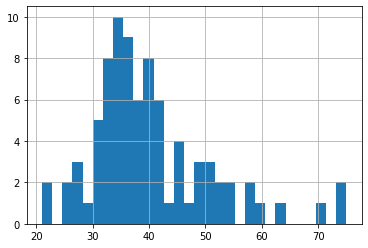

In [17]:
df.query('estimated_salary < 1500')['age'].hist(bins=30);

In [18]:
df.query('estimated_salary < 1500')['city'].value_counts()

Ярославль         49
Ростов Великий    22
Рыбинск           12
Name: city, dtype: int64

Вывод 1

1. В данных 10000 уникальных клиентов, проверена реалистичность данных, наличие дубликатов, корректность названий столбцов.

2. Пропуски имеются только в столбце с балансом. Примечательно, что пропуски есть только у клиентов из Рыбинска и Ярославля, при этом ни одного пропуска нет у клиентов из Ростова Великого, что может говорить о техническом сбое в первых двух городах. Пропуски оставлены. 

3. В столбце с заработной платой есть значения ниже пособия по безработице, не говоря уже о минимальной ставке заработной платы. Причина неизвестна, возможно, с определенной частотой во всех городах менеджеры отеделений забывают добавить к числу два или три нуля. Аномальные значения оставлены.


<div class="alert alert-success">
<b>Комментарий тимлида:</b> Супер !
</div>

### Категоризация данных

In [19]:
df.describe()

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.573368e+07,650.528800,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.560844e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.567126e+07,584.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.573347e+07,652.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.579597e+07,718.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.585843e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Для начала проведем категоризацию клиентов по уровню дохода.

МРОТ для Ярославской области на 1 января 2023 года составляет 16242 рубля, округлим до 16000. Средняя зарплата для Ярославской области в 2021 году составляла 40307 рублей, округлим до 40000. 

Установим следующие границы для категоризации клиентов по уровню дохода:

1. ниже 16000 рублей - ниже МРОТ
2. 16000 - 40000 - низкий 
3. 40000 - 100000 - средний
4. 100000 и более - высокий

In [20]:
def category_by_estimated_salary(df):
    
    if df['estimated_salary'] <= 16000:
        return 'крайне низкий'
    
    elif df['estimated_salary'] <= 40000:
        return 'низкий'
    
    elif df['estimated_salary'] <= 100000:
        return 'средний'
    
    else:
        return 'высокий'

df['salary_level'] = df.apply(category_by_estimated_salary, axis=1)

In [21]:
df['salary_level'].value_counts()

высокий          5010
средний          3035
низкий           1161
крайне низкий     794
Name: salary_level, dtype: int64

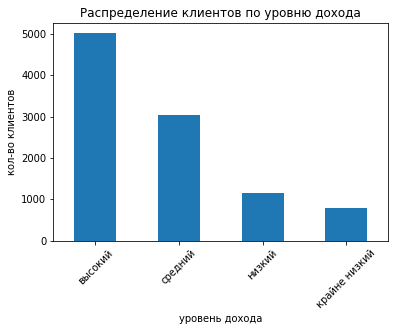

In [22]:
df['salary_level'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=45)
plt.ylabel('кол-во клиентов')
plt.xlabel('уровень дохода')
plt.title('Распределение клиентов по уровню дохода');

Проведем категоризацию клиентов банка по возрасту:

Выделим следующие возрастные группы:

1. 18-24 - молодежь, иногда распологающая собственными источниками заработка

2. 25-44 - экономически активное население с маленькими детьми и собственными источниками заработка

3. 45-64 - экономически активное население со взрослыми детьми и собственными источниками заработка

4. 65 и старшие - люди пенсионного возраста без собственных источников заработка

In [23]:
def category_by_age(df):
    
    if 18 <= df['age'] <= 24:
        return '18-24'
    
    elif 25 <= df['age'] <= 44:
        return '25-44'
    
    elif 45 <= df['age'] <= 64:
        return '45-64'
    
    else:
        return '65 и старше'

df['age_category'] = df.apply(category_by_age, axis=1)

In [24]:
df['age_category'].value_counts()

25-44          7203
45-64          2058
18-24           457
65 и старше     282
Name: age_category, dtype: int64

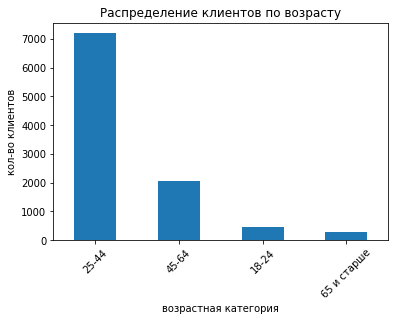

In [25]:
df['age_category'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=45)
plt.ylabel('кол-во клиентов')
plt.xlabel('возрастная категория')
plt.title('Распределение клиентов по возрасту');

Добавим категоризация клиентов по уровню кредитного скоринга.

Ресурс банки.ру предлагает следующую шкалу кредитного рейтинга заемщиков. Воспользуемся ею:
    
1. 0-399 - вероятность получения кредита отсутствует, крайне низкий уровень

2. 400-599 - вероятность получения кредита мала, низкий уровень

3. 600-799 - вероятность получения кредита выше среднего, средний уровень

4. 800 и более - вероятность получения кредита 100%, высокий уровень


<div class="alert alert-success">
<b>Комментарий тимлида:</b>  Очень круто, что ты обосновываешь 
    метод категоризации данных, в будущем тебе это точно пригодитя
</div>

In [26]:
def category_by_score(df):
    
    if df['score'] < 400:
        return 'крайне низкий'
    
    elif 400 <= df['score'] < 600:
        return 'низкий'
    
    elif 600 <= df['score'] < 800:
        return 'средний'
    
    else:
        return 'высокий'


df['score_level'] = df.apply(category_by_score, axis=1)

In [27]:
df['score_level'].value_counts()

средний          6311
низкий           3015
высокий           655
крайне низкий      19
Name: score_level, dtype: int64

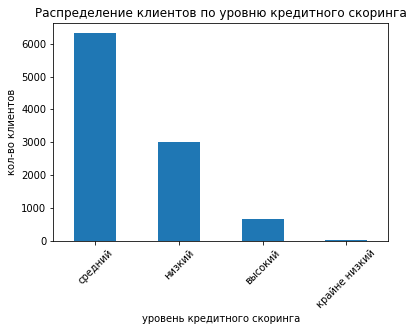

In [28]:
df['score_level'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=45)
plt.ylabel('кол-во клиентов')
plt.xlabel('уровень кредитного скоринга')
plt.title('Распределение клиентов по уровню кредитного скоринга');

Также добавим категоризацию клиентов банка по уровню баланса на счете.

Установим следующие, не очень реалистичные, но подходящие для датасета границы групп клиентов в разрезе уровня баланса на счете:

1. До 100000 - крайне низкий уровень баланса

2. 100000-300000 - низкий уровень баланса

3. 300000-1000000 - средний уровень баланса

4. 1000000 и выше - высокий уроень баланса

In [29]:
def category_by_balance(df):
    
    if df['balance'] < 50000:
        return 'крайне низкий'
    
    elif 50000 <= df['balance'] < 100000:
        return 'низкий'
    
    elif 100000 <= df['balance'] < 150000:
        return 'средний'
    
    elif df['balance'] >= 150000:
        return 'высокий'

df['balance_level'] = df.apply(category_by_balance, axis=1)

In [30]:
df['balance_level'].value_counts()

средний          3830
низкий           1509
высокий           969
крайне низкий      75
Name: balance_level, dtype: int64

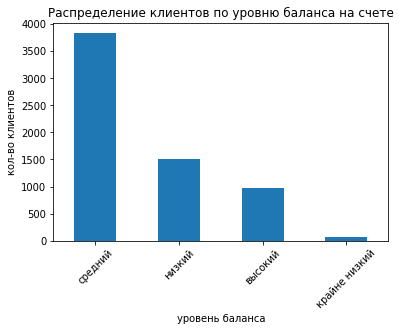

In [31]:
df['balance_level'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=45)
plt.ylabel('кол-во клиентов')
plt.xlabel('уровень баланса')
plt.title('Распределение клиентов по уровню баланса на счете');

In [32]:
df.head()

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,salary_level,age_category,score_level,balance_level
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,высокий,25-44,средний,None
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,высокий,25-44,средний,низкий
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,высокий,25-44,низкий,высокий
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0,средний,25-44,средний,None
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,средний,25-44,высокий,средний


Вывод 2

Проведена категоризация клиентов банка по следующим характеристикам: уровень дохода, возраст, уровень кредитного скоринга и уровень баланса на счете. 

1. В разрезе возраста в датасете преобладают клиента 25-44 лет.

2. По уровню дохода в датасете преимущественно люди с высокой заработной платой (более 100000 рублей).

3. Больше всего клиентов со средним уровнем кредитного скоринга (600-800 баллов).

4. В разрезе баланса на счете преобладают клиенты со средним уровнем баланса (100000-150000 рублей).

Сделаем кодировку данных для столбца с полом клиента.
Обозначим за 0 женский пол и за 1 мужской пол.

In [33]:
df['gender'] = df['gender'].replace({'Ж':0, 'М': 1})

## Исследовательский анализ данных

### Анализ средних значений признаков и их распределений

In [36]:
df.describe()

,user_id,score,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.573368e+07,650.528800,0.545700,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,0.497932,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.560844e+07,350.000000,0.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.567126e+07,584.000000,0.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.573347e+07,652.000000,1.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.579597e+07,718.000000,1.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.585843e+07,850.000000,1.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Среднестатистический клиент банка имеет следующие характеристики:
    
* Имеет кредитный рейтинг в 650 баллов

* С бОльшей вероятностью мужчина, хотя распределение клиентов по полу примерно равное

* Его возраст 39 лет

* Имеет в собственности 5 объектов 

* Имеет на счету 120000 рублей

* Пользуется 1 или 2 продуктами банка

* Скорее всего, имеет кредитную карту банка (с вероятностью в 70%)

* Имеет заработную плату в 100000 рублей

Также можно сказать, что половина клиентов из датасета активны, а отток составляет 20%.


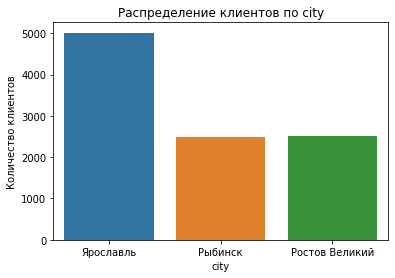

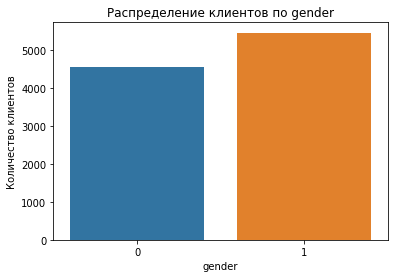

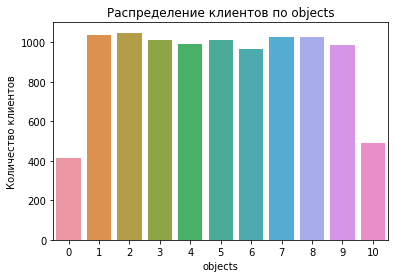

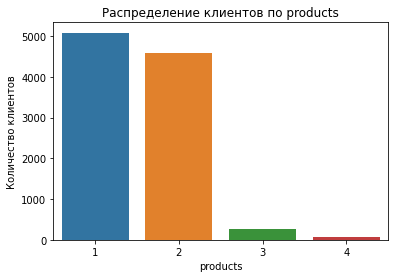

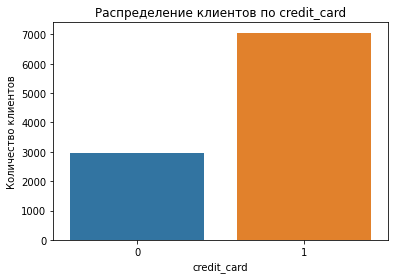

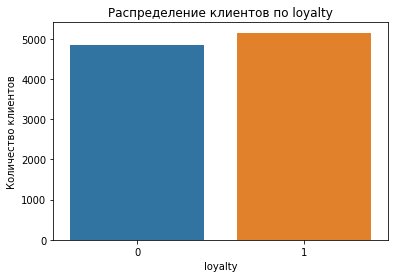

In [37]:
#посмотрим на распределение признаков с дискретными значениями
for column in df[['city', 'gender', 'objects', 'products', 'credit_card', 'loyalty']].columns:
    ax = sns.countplot(x = column, data = df)
    plt.title('Распределение клиентов по ' + column)
    plt.ylabel('Количество клиентов')
    plt.show();

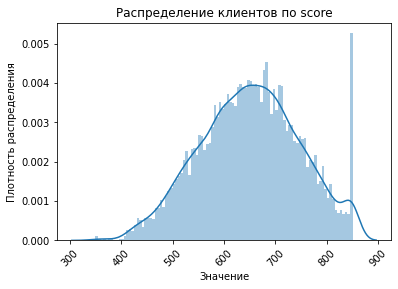

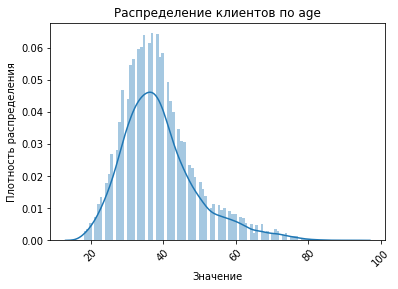

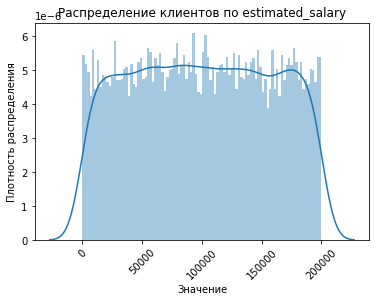

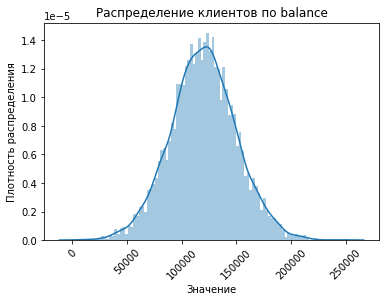

In [38]:
#посмотрим на распределение признаков с непрерывнми значениями (возраст отнесем в эту категорию)
for column in df[['score', 'age', 'estimated_salary', 'balance']].columns:
    sns.distplot(df[column], bins=100)
    plt.xticks(rotation=45)
    plt.title('Распределение клиентов по ' + column)
    plt.ylabel('Плотность распределения')
    plt.xlabel('Значение')
    plt.show();

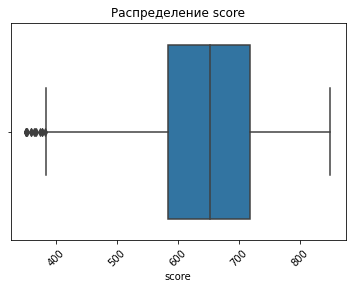

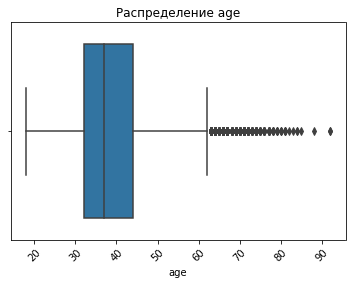

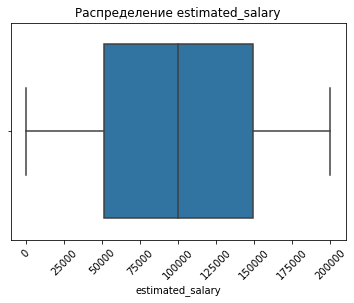

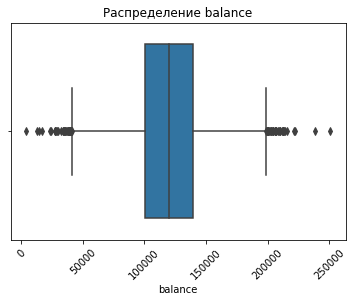

In [39]:
#посмотрим на диаграммы размахов признаков с непрерывными значениями (в т.ч. возраст)
for column in df[['score', 'age', 'estimated_salary', 'balance']]:
    ax = sns.boxplot(x=df[column])
    plt.xticks(rotation=45)
    plt.title('Распределение ' + column)
    plt.show();

Говоря о распределении значения признаков клиентов можно отметить следующее:

1. Странно распределены значения в столбце с кол-вом объектов в собственности клиентов. Так, от 1 до 9 объектов имеют одинаковое количество клиентов, примерно по 1000 человек.

2. На гистограмме распределения уровня баланс есть выброс на значении в 850 баллов - 233 человека. По всей видимости, шкала оценки кредитного рейтинга в банке ограничено 850 баллами, при этом клиенты могут иметь рейтинг выше, все кто, имеют рейтинг выше получают рейтинг в 850 баллов.

3. В датасете также подозрительно равномерно клиенты распределены по уровню заработной платы.

In [40]:
df['score'].value_counts().head()

850    233
678     63
655     54
667     53
705     53
Name: score, dtype: int64

### Матрица корреляции

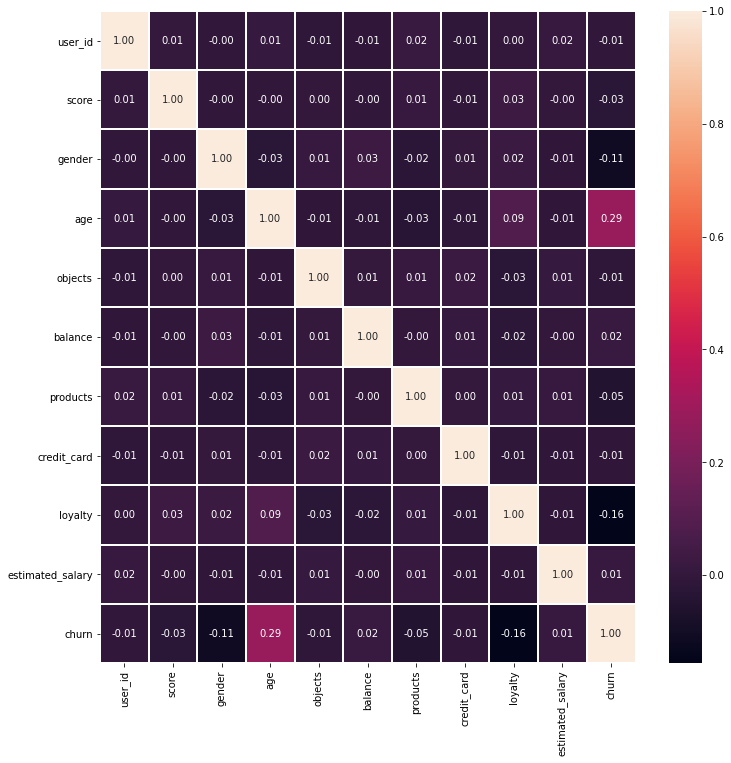

In [41]:
#построим матрицу корреляции для признаков клиентов банка
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr() , annot = True, fmt = '0.2f', linewidths=1)
plt.show();

Матрица корреляции демонстрирует почти полное отсутствие влияния характеристик клиентов на отток. Только влияние возраста на отток (коэф. корреляции = 0.29) можно считать слабым, остальные же признаки вовсе не влияют на отток. Исходя из этого, можно сделать вывод, что очевидного признака, объясняющего склонность клиента к уходу из банка нет.

### Анализ распределения характеристик клиентов в разрезе ухода или лояльности банку

In [43]:
df.groupby('churn').mean().T

churn,0,1
user_id,1.573390e+07,1.573279e+07
score,6.518532e+02,6.453515e+02
gender,5.725229e-01,4.408444e-01
age,3.740839e+01,4.483800e+01
objects,5.033279e+00,4.932744e+00
balance,1.195359e+05,1.207470e+05
products,1.544267e+00,1.475209e+00
credit_card,7.071455e-01,6.990673e-01
loyalty,5.545649e-01,3.608247e-01
estimated_salary,9.973839e+04,1.014657e+05


На первый взгляд кажется, что ушедшие и лояльные банку клиенты по характеристикам отличаются несильно. Очевидными различиями являются только возраст, попадающие в отток клиенты в среднем более старше, чем лояльные (45 лет против 37 лет), и бОльший процент активных клиентов среди лояльных клиентов, нежели отточных (55% против 36% против). Также можно заметить, что в отток чаще попадают клиенты женского пола.

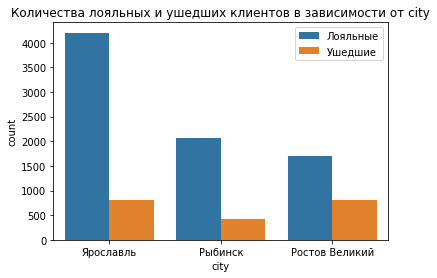

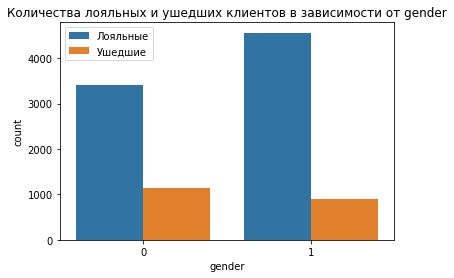

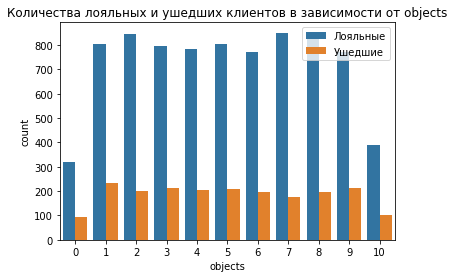

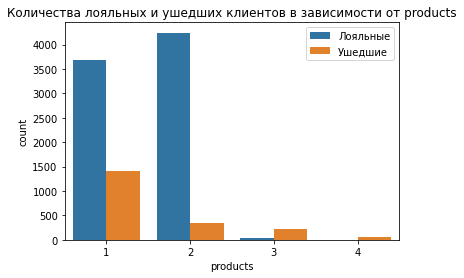

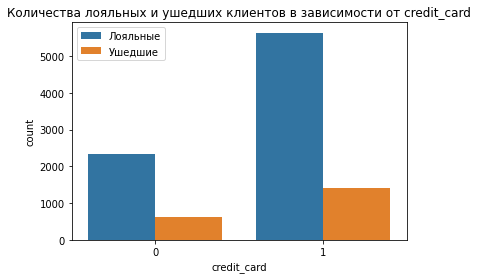

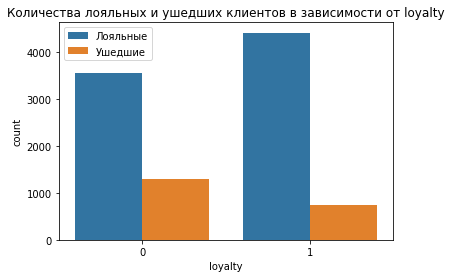

In [44]:
#посмотрим на распределение признаков с дискретными значениями
for column in df[['city', 'gender', 'objects', 'products', 'credit_card', 'loyalty']].columns:
    ax = sns.countplot(x = column, hue = 'churn', data = df)
    plt.title('Количества лояльных и ушедших клиентов в зависимости от ' + column)
    plt.legend(['Лояльные', 'Ушедшие'])
    plt.show();

In [45]:
churn_by_city = df.pivot_table(
        columns='city',
        values='churn',
        aggfunc='mean'
    ).round(2).T
churn_by_city

,churn
city,
Ростов Великий,0.32
Рыбинск,0.17
Ярославль,0.16


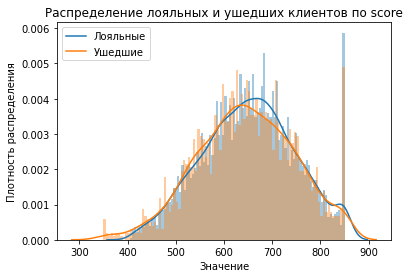

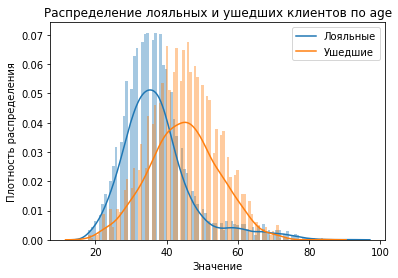

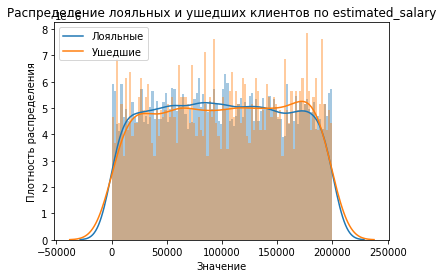

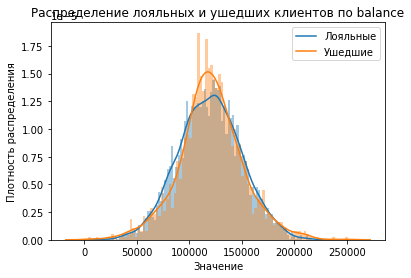

In [46]:
#посмотрим на распределение признаков с непрерывнми значениями (возраст отнесем в эту категорию)
for column in df[['score', 'age', 'estimated_salary', 'balance']].columns:
    sns.distplot(df.query('churn == 0')[column], bins = 100)
    sns.distplot(df.query('churn == 1')[column], bins = 100)
    plt.title('Распределение лояльных и ушедших клиентов по ' + column)
    plt.ylabel('Плотность распределения')
    plt.xlabel('Значение')
    plt.legend(['Лояльные', 'Ушедшие'])
    plt.show();

В разрезе городов очевидным лидером по доле отточных клиентов является Ростов Великий (32%). Доля ушедших клиентов в Рыбинске и Ярославле почти равна и в 2 раза ниже, чем в Ростове (16%-17%).

Заметно превышение доли ушедших среди клиентов, пользующихся 3-4 продуктами банка, нежели среди клиентов, пользующихся 1-2 продуктами.

Также видно преобладание отточников среди клиентов с рейтингом кредитного скоринга примерно до 410 баллов. Вероятность оттока в данной группе составляет 92%, но ее численность всего 26 человек, поэтому не будем уделять ей внимание.

In [47]:
df.query('score < 410')['churn'].mean()

0.9230769230769231

In [48]:
df.query('score < 410')['churn'].count()

26

Исходя из того, что характеристиками, демонстрирующими различия между лояльными и отточными клиентами являются город, возраст, активность, пол и количество продуктов, которыми пользуется клиент, выделять более склонные к оттоку сегменты клиентов будем на основе данных признаков.

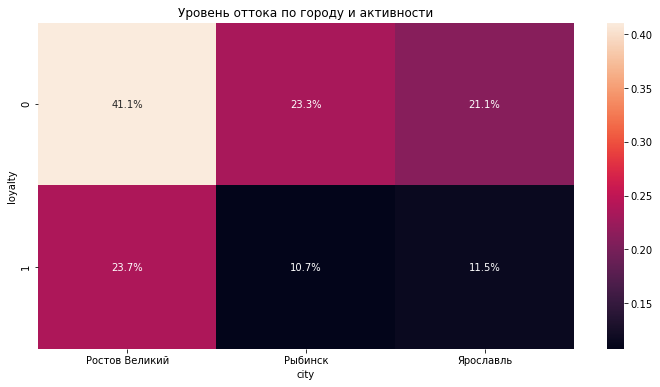

In [49]:
#построим тепловую карту уровня оттока по городу и активности
churn_by_city_loyalty = df.pivot_table(
        index='loyalty',
        columns='city',
        values='churn',
        aggfunc='mean'
    )
plt.figure(figsize=(12, 6))
sns.heatmap(churn_by_city_loyalty, annot=True, fmt='.1%')
plt.title('Уровень оттока по городу и активности')
plt.show();

Наибольшая доля ушедших - из Ростова Великого и неактивны.

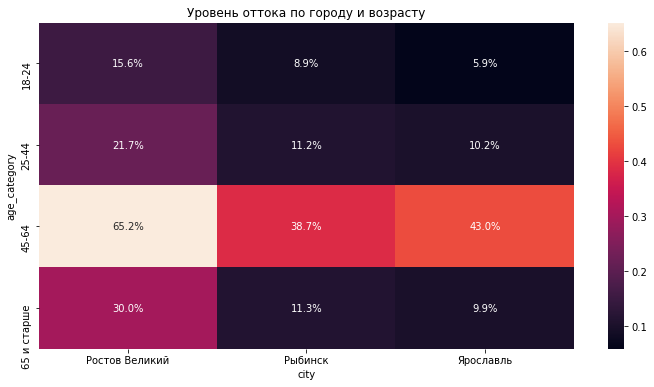

In [50]:
#построим тепловую карту уровня оттока по городу и возрасту
churn_by_city_age = df.pivot_table(
        index='age_category',
        columns='city',
        values='churn',
        aggfunc='mean'
    )
plt.figure(figsize=(12, 6))
sns.heatmap(churn_by_city_age, annot=True, fmt='.1%')
plt.title('Уровень оттока по городу и возрасту')
plt.show();

Очень четко выделяется склонность возрастной группы 45-64 к оттоку.

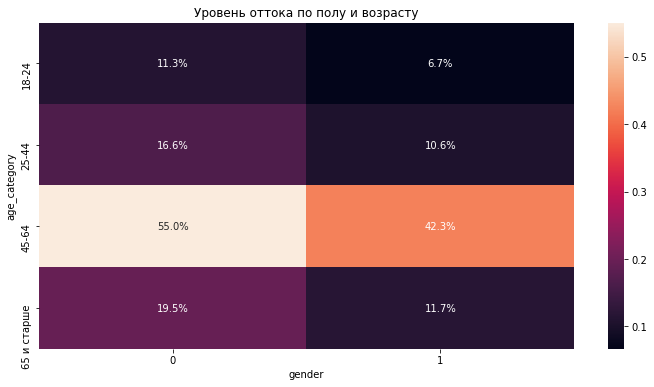

In [51]:
#построим тепловую карту уровня оттока по возрасту и полу
churn_by_gender_age = df.pivot_table(
        index='age_category',
        columns='gender',
        values='churn',
        aggfunc='mean'
    )
plt.figure(figsize=(12, 6))
sns.heatmap(churn_by_gender_age, annot=True, fmt='.1%')
plt.title('Уровень оттока по полу и возрасту')
plt.show();

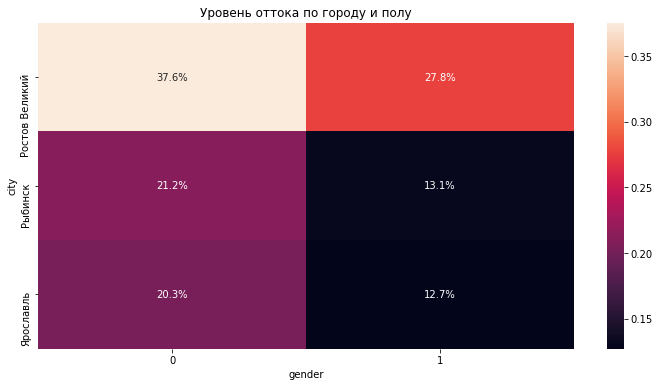

In [52]:
#построим тепловую карту уровня оттока по городу и полу
churn_by_city_gender = df.pivot_table(
        index='city',
        columns='gender',
        values='churn',
        aggfunc='mean'
    )
plt.figure(figsize=(12, 6))
sns.heatmap(churn_by_city_gender, annot=True, fmt='.1%')
plt.title('Уровень оттока по городу и полу')
plt.show();

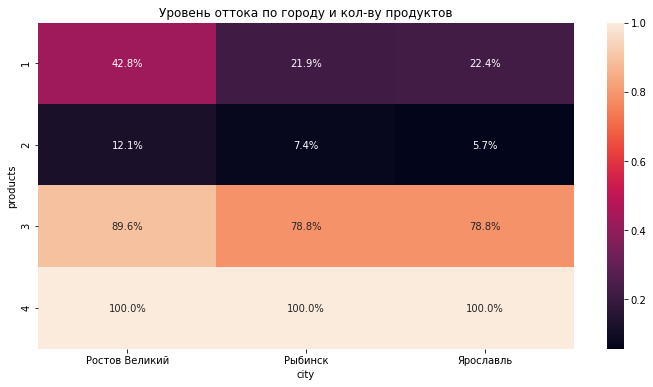

In [53]:
#построим тепловую карту уровня оттока по городу и кол-ву продуктов
churn_by_city_products = df.pivot_table(
        index='products',
        columns='city',
        values='churn',
        aggfunc='mean'
    )
plt.figure(figsize=(12, 6))
sns.heatmap(churn_by_city_products, annot=True, fmt='.1%')
plt.title('Уровень оттока по городу и кол-ву продуктов')
plt.show();

Выделим следующие сегменты клиентов, склонных к оттоку:

1. Все клиенты, пользующиеся 3 или 4 продуктами банка.

2. Клиенты из Ростова Великого, женщины, возраста 45-64, неактивные пользователи с 1-2 продуктами.

3. Клиенты из Ростова Великого, мужчины, возраста 45-64, неактивные пользователи с 1-2 продуктами.

4. Клиенты из Ярославля, женщины, возраста 45-64, неактивные пользователи с 1-2 продуктами.

5. Клиенты из Рыбинска, женщины, возраста 45-64, неактивные пользователи с 1-2 продуктами.

In [54]:
#посмотрим на доли отточных в выделенных сегментах и превышение долей над средней долей оттока
segments = [
    ("все клиенты с 3-4 продуктами", 'products > 2'),
    ("ростовчане женщины 45-64 неактивные 1-2 продукта", 'city == "Ростов Великий" & gender == 0 & age_category == "45-64" & loyalty == 0 & products <= 2'),
    ("ростовчане мужчины 45-64 неактивные 1-2 продукта", 'city == "Ростов Великий" & gender == 1 & age_category == "45-64" & loyalty == 0 & products <= 2'),
    ("ярославцы женщины 45-64 неактивные 1-2 продукта", 'city == "Ярославль" & gender == 0 & age_category == "45-64" & loyalty == 0 & products <= 2'),
    ("рыбинцы женщины 45-64 неактивные 1-2 продукта", 'city == "Рыбинск" & gender == 0 & age_category == "45-64" & loyalty == 0 & products <= 2'),
    ("ростовчане женщины страше 65 неактивные 1-2 продукта",'city == "Ростов Великий" & gender == 0 & age_category == "65 и старше" & loyalty == 0 & products <= 2')
]
seg = []
for text, query in segments:
    result = df.query(query)\
              .agg({"churn":['count','mean']}).round(2).T
    result.index = [text]
    seg.append(result)
segments_data = pd.concat(seg)
segments_data['churn_surplus'] = (segments_data['mean'] - df.churn.mean()).round(2)
segments_data.sort_values(by='churn_surplus', ascending=False).rename(columns={'mean':'churn_mean'})

,count,churn_mean,churn_surplus
все клиенты с 3-4 продуктами,326.0,0.86,0.66
ростовчане мужчины 45-64 неактивные 1-2 продукта,137.0,0.78,0.58
ростовчане женщины 45-64 неактивные 1-2 продукта,166.0,0.77,0.57
ростовчане женщины страше 65 неактивные 1-2 продукта,7.0,0.71,0.51
ярославцы женщины 45-64 неактивные 1-2 продукта,186.0,0.67,0.47
рыбинцы женщины 45-64 неактивные 1-2 продукта,101.0,0.62,0.42


Вывод 3

1. Корреляционный анализ показал, что очевидного признака, объясняющего склонность клиента к уходу из банка нет. Только такой признак как возраст имеет слабое влияние на отток (коэф. корреляции = 0.29), остальные признаки вовсе не объясняют склонность клиента к оттоку.

2. В общем, клиент, склонный к уходу в отток, имеет следующий портрет:

* скорее проживает в Ростове Великом

* с бОльшей вероятностью женского пола

* состоит в возрастной категории 45-64 года

* неактивен

* пользуется 3-4 продуктами банка

3. На основании признаков клиентов, отображающих различия между лояльными и отточными клиентами, такими как город, возраст, активность, пол и количество продуктов, были выделены следующие сегменты отточников численностью более 10 человек:

* Сегмент 1. Клиенты с 3-4 продуктами вне зависимости от других признаков. 326 человек. Попадают в отток в 86% случаев.

* Сегмент 2. Ростовчане мужчины в возрасте 45-64 года, неактивные, с 1-2 продуктами. 137 человек. Попадают в отток в 78% случаев.

* Сегмент 3. Ростовчанки женщины в возрасте 45-64 года, неактивные, с 1-2 продуктами. 166 человек. Попадают в отток в 77% случаев.

* Сегмент 4. Ярославки женщины в возрасте 45-64 года, неактивные, с 1-2 продуктами. 186 человек. Попадают в отток в 67% случаев.

* Сегмент 5. Рыбинчанки женщины в возрасте 45-64 года, неактивные, с 1-2 продуктами. 101 человек. Попадают в отток в 62% случаев.

##  Проверка статистических гипотез

### Проверка гипотезы о различии дохода между ушедшими и лояльными клиентами банка

In [55]:
#Разделим датасет на ушедших и лояльных
df_churn_0 = df.query('churn == 0')
df_churn_1 = df.query('churn == 1')

Для применения t-теста для проверки гипотезы убедимся, что данные распределены нормально и дисперсии двух выборок не сильно отличаются.

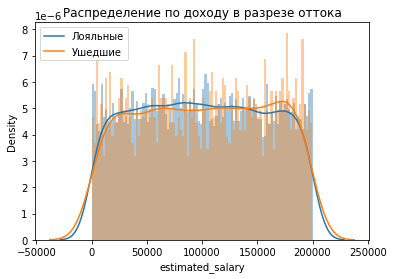

In [56]:
sns.distplot(df_churn_0['estimated_salary'], bins=100)
sns.distplot(df_churn_1['estimated_salary'], bins=100)
plt.title('Распределение по доходу в разрезе оттока')
plt.legend(['Лояльные', 'Ушедшие'])
plt.show();

In [57]:
print('Кол-во ушедших: ', len(df_churn_1['estimated_salary']))
print('Кол-во лояльных: ', len(df_churn_0['estimated_salary']))

print('Дисперсия ушедших:',df_churn_1['estimated_salary'].var())
print('Дисперсия лояльных:',df_churn_0['estimated_salary'].var())

Кол-во ушедших:  2037
Кол-во лояльных:  7963
Дисперсия ушедших: 3353848166.8070116
Дисперсия лояльных: 3295401414.9183965


Дисперсии почти равны, но распределение не похоже на нормальное, поэтому для проверки гипотезы воспользуемся U-критерием Манна — Уитни. Используем уровень стат. значимости в 5%.

Гипотеза H0: доход среди тех клиентов, которые ушли и тех, которые остались, не различаются

Гипотеза H1: доход среди тех клиентов, которые ушли и тех, которые остались, различаются

In [58]:
alpha = 0.05 

results = st.mannwhitneyu(
    df_churn_0['estimated_salary'], 
    df_churn_1['estimated_salary'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.22705150930153783
Не получилось отвергнуть нулевую гипотезу


### Проверка гипотезы о различии уровня кредитного скоринга между ушедшими и лояльными клиентами банка

Для применения t-теста для проверки гипотезы убедимся, что данные распределены нормально и дисперсии двух выборок не сильно отличаются.

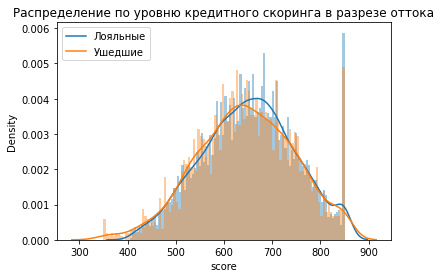

In [59]:
sns.distplot(df_churn_0['score'], bins=100)
sns.distplot(df_churn_1['score'], bins=100)
plt.title('Распределение по уровню кредитного скоринга в разрезе оттока')
plt.legend(['Лояльные', 'Ушедшие'])
plt.show();

In [60]:
print('Кол-во ушедших: ', len(df_churn_1['estimated_salary']))
print('Кол-во лояльных: ', len(df_churn_0['estimated_salary']))

print('Дисперсия ушедших:',df_churn_1['score'].var())
print('Дисперсия лояльных:',df_churn_0['score'].var())

Кол-во ушедших:  2037
Кол-во лояльных:  7963
Дисперсия ушедших: 10064.403893876835
Дисперсия лояльных: 9149.656541843884


Дисперсии различаются в пределах 10%, но распределение опять не является нормальных из-за того, что хвост справа скошен, и есть выброс на отметке в 850 баллов. Поэтому опять применим U-критерий Манна — Уитни для проверки гипотезы. Уровень стат. значимости - 5%.

Гипотеза H0: уровень кредитного скоринга среди тех клиентов, которые ушли и тех, которые остались, не различаются

Гипотеза H1: уровень кредитного скоринга среди тех клиентов, которые ушли и тех, которые остались, различаются

In [61]:
alpha = 0.05 

results = st.mannwhitneyu(
    df_churn_0['score'], 
    df_churn_1['score'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.01986866117272834
Отвергаем нулевую гипотезу


### Проверка гипотезы о различии уровня баланса на счете между ушедшими и лояльными клиентами банка

In [62]:
#создадим копию датасета без пропусков в столбце с балансом
new_df = df[~np.isnan (df['balance'])]

In [63]:
#Разделим новый датасет на ушедших и лояльных
new_df_churn_0 = new_df.query('churn == 0')
new_df_churn_1 = new_df.query('churn == 1')

Для применения t-теста для проверки гипотезы убедимся, что данные распределены нормально и дисперсии двух выборок не сильно отличаются.

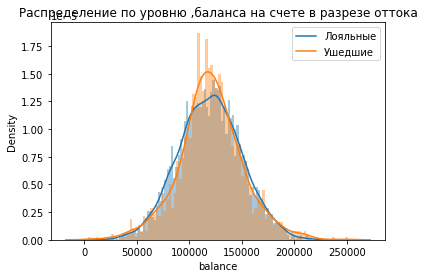

In [64]:
sns.distplot(new_df_churn_0['balance'], bins=100)
sns.distplot(new_df_churn_1['balance'], bins=100)
plt.title('Распределение по уровню ,баланса на счете в разрезе оттока')
plt.legend(['Лояльные', 'Ушедшие'])
plt.show();

In [65]:
print('Кол-во ушедших: ', len(new_df_churn_1['balance']))
print('Кол-во лояльных: ', len(new_df_churn_0['balance']))

print('Дисперсия ушедших:', new_df_churn_1['balance'].var())
print('Дисперсия лояльных:', new_df_churn_0['balance'].var())

Кол-во ушедших:  1537
Кол-во лояльных:  4846
Дисперсия ушедших: 933619807.1817832
Дисперсия лояльных: 896698675.3393947


Данные распределены нормально, дисперсии различаются в пределах 10%, поэтому для проверки гипотезы можно вспользоваться t-тестом.

Гипотеза H0: уровень баланса на счете среди тех клиентов, которые ушли и тех, которые остались, не различаются

Гипотеза H1: уровень баланса на счете среди тех клиентов, которые ушли и тех, которые остались, различаются

In [66]:
alpha = 0.05 

results = st.ttest_ind(
    new_df_churn_0['balance'], 
    new_df_churn_1['balance'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.16924734893322796
Не получилось отвергнуть нулевую гипотезу


Вывод 4

Проведены проверки 3 статистических гипотез о влиянии признаков клиентов на их склонность к оттоку. Получены следующие результаты:

1. Средние доход и баланс на счете между отточными и лояльными банку клиентами не различаются.

2. Средний уровень крединтного скоринга между отточными и лояльными банку клиентами разлчаются. В среднем у лояльных клиентов уровень кредитного скоринга немного выше, чем у склонных к оттоку. Тем не менее, данный признак для сегментации отточных клиентов использовать не будем. 

## Общие выводы исследования

1. В выборке представлена информация о 10000 уникальных клиентах банках. О портрете рядового клиента банка можно сказать следующее:

* Выборка по полу распределена равномерно

* 50% - клиенты из Ярославля, 25% - из Ростова Великого, 25% - из Рыбинска

* В разрезе возраста в датасете преобладают клиенты 25-44 лет

* По уровню дохода в датасете преимущественно люди с высокой заработной платой (более 100000 рублей)

* Больше всего клиентов со средним уровнем кредитного скоринга (600-800 баллов)

* В разрезе баланса на счете преобладают клиенты со средним уровнем баланса (100000-150000 рублей)

* В подавляющем большинстве клиенты пользуются 1-2 продуктами банка

* В среднем клиент имеет в собственности 5 объектов

* В 70% случаев клиенты имеют кредитную карту банка

* Примерно 50% клиентов - активные пользователи банка

* В 80% случаев клиент лоялен банку и не склонен к уходу


2. Отток клиентов в банке на данный момент составляет 20%. Корреляционный анализ не показал сильного влияния ни одного из признаков клиентов на склонность к оттоку.

В общем, клиент, склонный к уходу в отток, имеет следующий портрет:

* скорее проживает в Ростове Великом

* с бОльшей вероятностью женского пола

* состоит в возрастной категории 45-64 года

* неактивен

* пользуется 3-4 продуктами банка


3. Проверка статистических гипотез показала, что средние доход и баланс на счете между отточными и лояльными банку клиентами не различаются. 

4. На основании признаков клиентов, отображающих различия между лояльными и отточными клиентами, такими как город, возраст, активность, пол и количество продуктов, были выделены следующие сегменты отточников численностью более 100 человек:

* Сегмент 1. Клиенты с 3-4 продуктами вне зависимости от других признаков. 326 человек. Попадают в отток в 86% случаев.

* Сегмент 2. Ростовчане мужчины в возрасте 45-64 года, неактивные, с 1-2 продуктами. 137 человек. Попадают в отток в 78% случаев.

* Сегмент 3. Ростовчанки женщины в возрасте 45-64 года, неактивные, с 1-2 продуктами. 166 человек. Попадают в отток в 77% случаев.

* Сегмент 4. Ярославки женщины в возрасте 45-64 года, неактивные, с 1-2 продуктами. 186 человек. Попадают в отток в 67% случаев.

* Сегмент 5. Рыбинчанки женщины в возрасте 45-64 года, неактивные, с 1-2 продуктами. 101 человек. Попадают в отток в 62% случаев.

## Рекомендации отделу маркетинга по минимазации оттока

1. Повсеместно провести мониторинг активности клиентов с 3-4 продуктами. Провести мероприятия по улучшению клиентского опыта взаимодействия с банком, например, закреплять за клиентом с 3 продуктами и более персонального менеджера. Сформировать пакетное предложение для клиентов с 3-4 продуктами (например, карта+вклад+страхование) с условиями, выгоднее, чем при отдельном использовании продуктов.

2. Провести анализ качества обслуживания клиентов банка в Ростове Великом. Провести анализ конкурентной среды в этом городе, возможно конкуренты предлагают клиентам более выгодные условия по банковским продуктам.

3. Повсеместно провести разработку выгодных предложений для людей в возрасте 45-64 года. Проанализировать, какие категории трат преобладают в структуре трат у этой возрастной группы, и предложить на эти категории повышенный кэшбек. Разработать вклад с выгодными условиями конкретно для этой возрастной группы, но не очень дискриминирующий другие возрастные группы. Привлечь к сотрудничеству по программе лояльности партнеров, услугами которых склонны пользоваться люди в возрастной группе 45-64. Предложить выгодные условия по кредиту для целей, характерных этой возрастной группе.

4. Повсеместно принять меры по повышению процента активных пользователей. Например, сохранять для клиентов привлекательные условия по начислению процентов на остаток по счету, получению кэшбека и льготной цене на обслужвание карты при осуществлении минимум 2-3 покупок по карте в месяц.